# **Importing the modules**

In [31]:
import numpy as np
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,  ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


# **Loading the Dataset**

In [13]:
twitter_data=pd.read_csv("/content/Twitter_Data.csv")
twitter_data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [16]:
twitter_data.shape

(162980, 2)

In [17]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [18]:
twitter_data['category'].value_counts()

 1.0    72250
 0.0    55213
-1.0    35510
Name: category, dtype: int64

In [19]:
labels = pd.get_dummies(twitter_data.category)
labels.columns = ["negative", "neutral", "positive"]
labels.head()

,negative,neutral,positive
0,1,0,0
1,0,1,0
2,0,0,1
3,0,0,1
4,0,0,1


<Axes: xlabel='category', ylabel='count'>

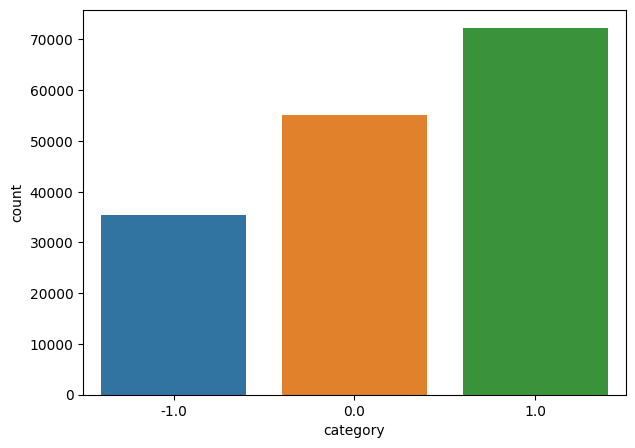

In [23]:

fig = plt.figure(figsize=(7,5))
sns.countplot(x="category",data=twitter_data)

Text(0.5, 1.0, 'Distribution of sentiments')

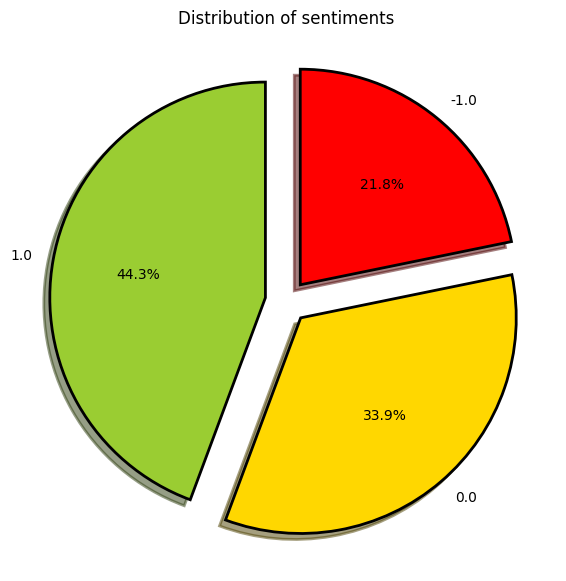

In [24]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = twitter_data['category'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

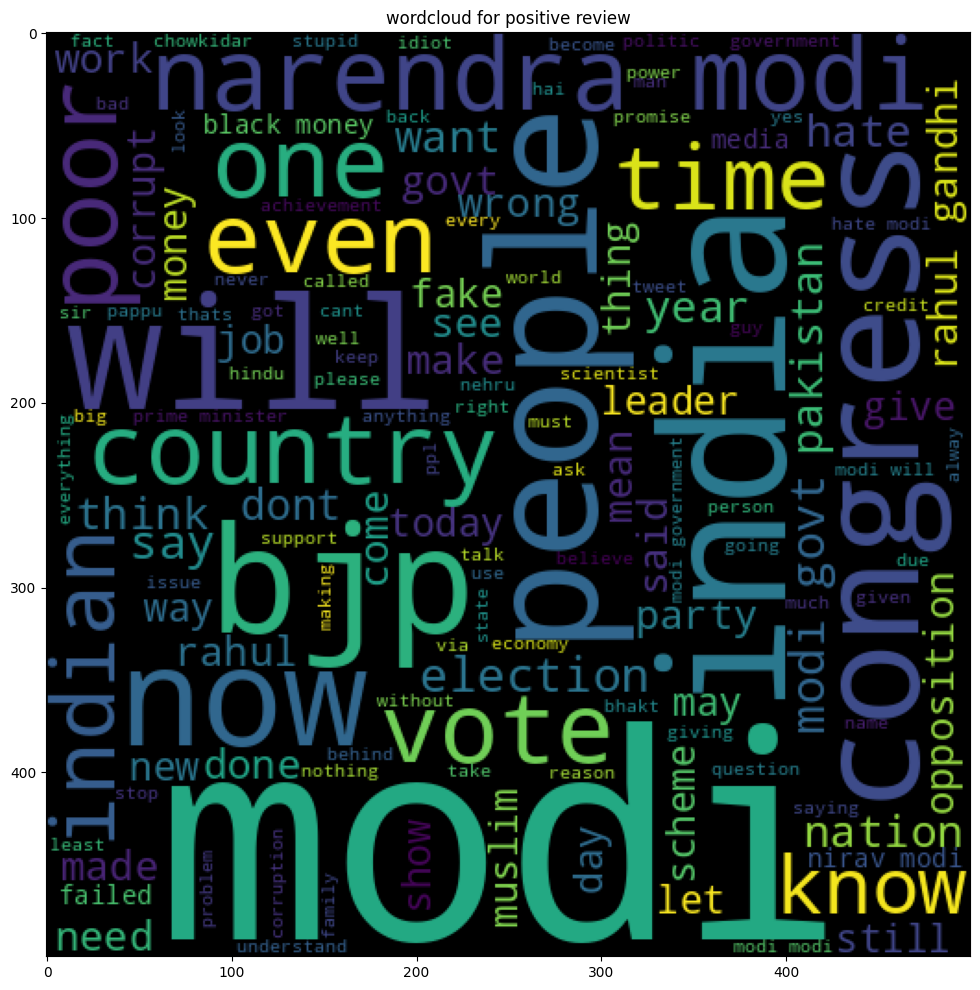

In [25]:
from wordcloud import WordCloud
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'black')
positive_wc = wc.generate(twitter_data[twitter_data['category'] == 1.0]['clean_text'].str.cat(sep = " "))
neutral_wc = wc.generate(twitter_data[twitter_data['category'] == 0.0]['clean_text'].str.cat(sep = " "))
negative_wc = wc.generate(twitter_data[twitter_data['category'] == -1.0]['clean_text'].str.cat(sep = " "))
plt.figure(figsize = (12, 12))
plt.title('wordcloud for positive review')
plt.imshow(positive_wc)

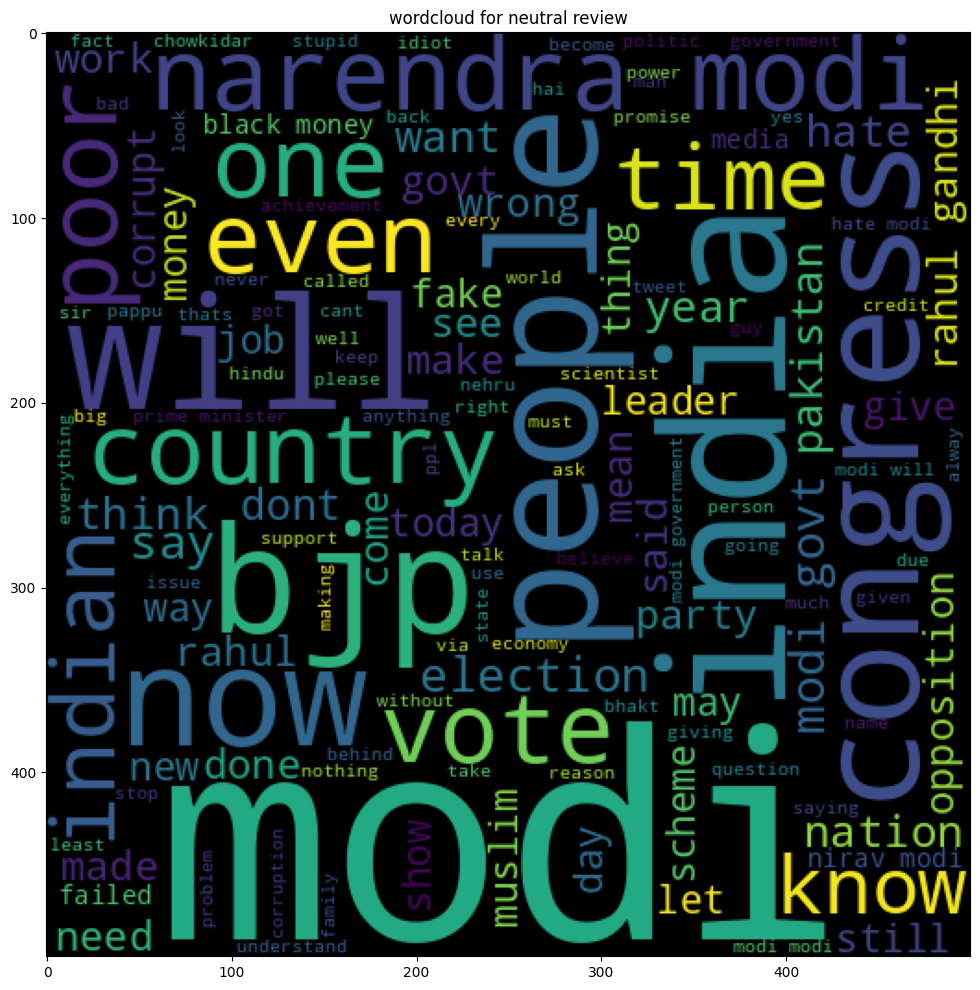

In [26]:
plt.figure(figsize = (12, 12))
plt.title('wordcloud for neutral review')
plt.imshow(neutral_wc)

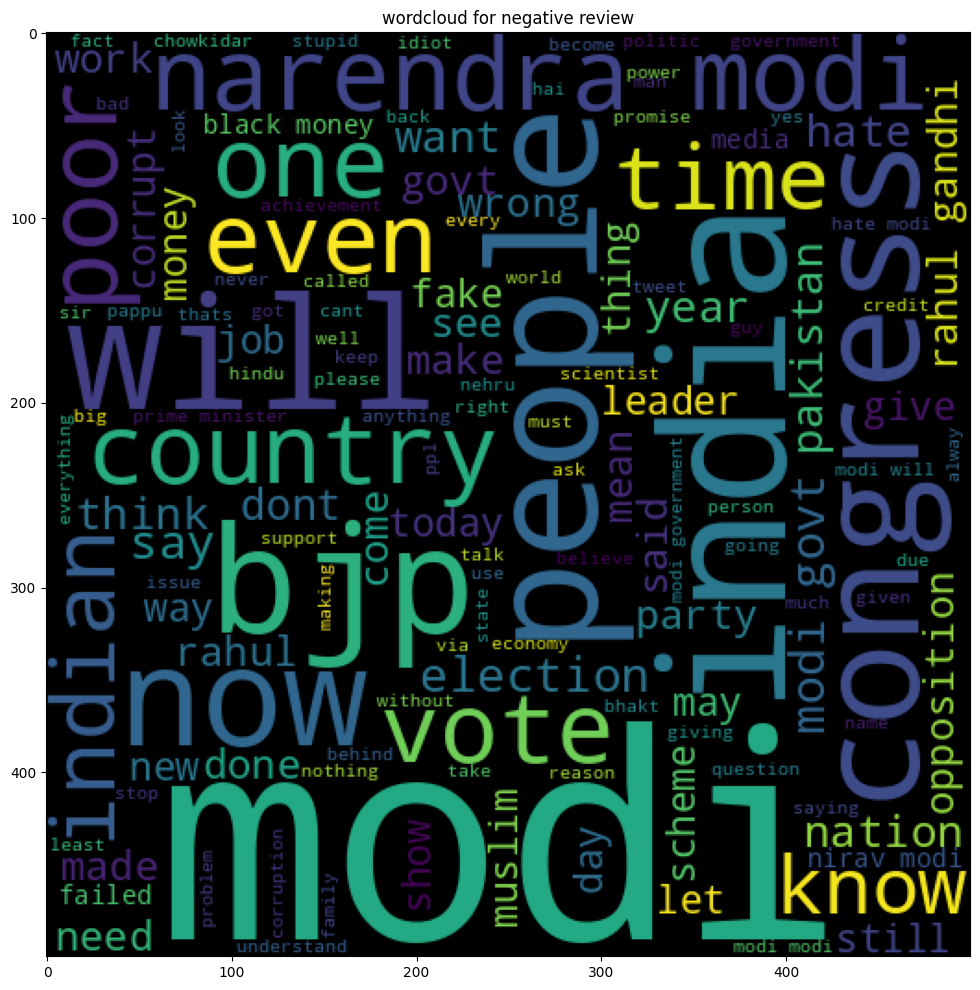

In [27]:
plt.figure(figsize = (12, 12))
plt.title('wordcloud for negative review')
plt.imshow(negative_wc)



In [29]:
X = twitter_data['clean_text'].values.astype('U')
y = twitter_data['category'].values.astype('U')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)

In [30]:
pipe = Pipeline([('tfidf_vectorizer',TfidfVectorizer(lowercase = True, stop_words = 'english',analyzer = 'word')), ('naive_bayes', MultinomialNB())])
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

pipe.fit(list(X_train), list(y_train))
y_pred = pipe.predict(X_test)
print(confusion_matrix(y_pred, y_test))
print(accuracy_score(y_pred, y_test))
pipe['naive_bayes']

[[ 1397    48    69     0]
 [  437  5616   545     1]
 [ 8819 10900 21061     1]
 [    0     0     0     0]]
0.5741808810897042


MultinomialNB()

In [32]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

# Convert text to sequences
X_sequences = tokenizer.texts_to_sequences(X)

# Pad sequences to have consistent length
X_padded = pad_sequences(X_sequences)

# Split the data into training and testing sets
X_train_seq, X_test_seq, y_train, y_test = train_test_split(X_padded, labels, test_size=0.3, stratify=labels)


In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X_padded.shape[1]),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(3, activation='softmax')  # Assuming 3 classes: negative, neutral, positive
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [35]:
model.fit(X_train_seq, y_train, epochs=5, batch_size=64, validation_split=0.2)


Epoch 1/5
1427/1427 [==============================] - 627s 436ms/step - loss: 0.3202 - accuracy: 0.8827 - val_loss: 0.1609 - val_accuracy: 0.9522
Epoch 2/5
1427/1427 [==============================] - 618s 433ms/step - loss: 0.0989 - accuracy: 0.9695 - val_loss: 0.1306 - val_accuracy: 0.9599
Epoch 3/5
1427/1427 [==============================] - 643s 451ms/step - loss: 0.0512 - accuracy: 0.9836 - val_loss: 0.1230 - val_accuracy: 0.9624
Epoch 4/5
1427/1427 [==============================] - 653s 458ms/step - loss: 0.0294 - accuracy: 0.9908 - val_loss: 0.1360 - val_accuracy: 0.9602
Epoch 5/5
1427/1427 [==============================] - 650s 456ms/step - loss: 0.0160 - accuracy: 0.9951 - val_loss: 0.1522 - val_accuracy: 0.9633


In [36]:
loss, accuracy = model.evaluate(X_test_seq, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


1528/1528 [==============================] - 40s 26ms/step - loss: 0.1528 - accuracy: 0.9632
Test Loss: 0.15277081727981567, Test Accuracy: 0.9631856679916382


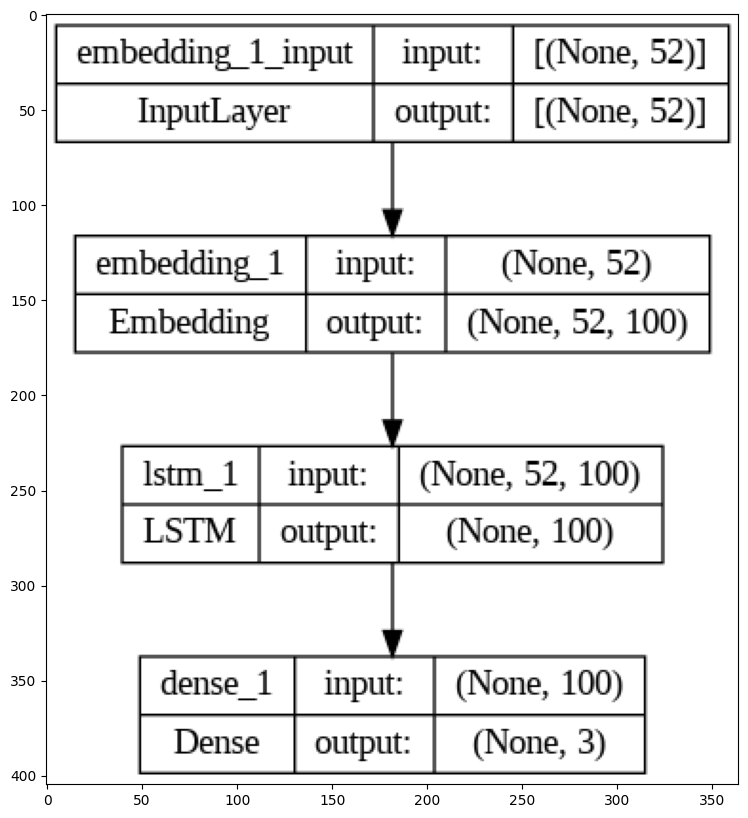

In [37]:
from tensorflow.keras.utils import plot_model
# Assuming 'model' is your Keras model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the plot
img = plt.imread('model_architecture.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()